In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import os




/home/ilee300/workspace/nlp_ofa/transformers/src/transformers/models/bert/modeling_bert.py:957: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self.encoder != None, "the encoder cannot be None")
/home/ilee300/workspace/nlp_ofa/transformers/src/transformers/models/bert/modeling_bert.py:960: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self.encoder.config.num_hidden_layers >= max_encoder_num, "the max encoder number should not exceed defined hidden layer")


In [2]:
print("checking time : " , time.time())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

checking time :  1629922663.590056
cuda:0


In [3]:
dirname = os.getcwd()

source_folder = os.path.join(dirname,'../data')
destination_folder =os.path.join(dirname,'../data/saved_models')

In [4]:
destination_folder

'/home/ilee300/workspace/nlp_ofa/transformers/notebooks/../data/saved_models'

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [6]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]
# fields = [('text', text_field),('sentiment', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True,shuffle=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True,shuffle=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=True, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (706 > 512). Running this sequence through the model will result in indexing errors


In [7]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [8]:

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [9]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf"),
         max_encoder_num = None):
    model.encoder.set_attention_head_number(4)
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    if max_encoder_num:
        model.encoder.set_max_encoder_num(max_encoder_num)
    else:
        max_encoder_num=model.encoder.config.num_hidden_layers
        model.encoder.set_max_encoder_num(model.encoder.config.num_hidden_layers)
        
    # training loop
    model.train()
    print("training the model with encoder number of " , max_encoder_num)
    for epoch in range(num_epochs):
        for (labels, title, text, titletext), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            titletext = titletext.type(torch.LongTensor)  
            titletext = titletext.to(device)
            output = model(titletext, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, title, text, titletext), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        titletext = titletext.type(torch.LongTensor)  
                        titletext = titletext.to(device)
                        output = model(titletext, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' +str(max_encoder_num)+ 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + str(max_encoder_num)+ 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' +str(max_encoder_num)+ 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [10]:
# Evaluation Function

def evaluate(model, test_loader,max_encoder_num=None ):
    y_pred = []
    y_true = []
    if max_encoder_num:
        model.encoder.set_max_encoder_num(max_encoder_num)
    else:
        max_encoder_num=model.encoder.config.num_hidden_layers
        model.encoder.set_max_encoder_num(model.encoder.config.num_hidden_layers)
    print("evaluating with max encoder number of ", max_encoder_num)
    model.eval()
    with torch.no_grad():
        for (labels, title, text, titletext), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                titletext = titletext.type(torch.LongTensor)  
                titletext = titletext.to(device)
                output = model(titletext, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_pred,y_true)

In [11]:
model = BERT().to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['bert.encoder.layer.1.attention.self.key.bias', 'bert.encoder.layer.11.attention.self.value.bias', 'bert.encoder.layer.10.attention.self.query.weight', 'bert.encoder.layer.10.attention.self.key.bias', 'bert.encoder.layer.6.attention.self.value.bias', 'bert.encoder.layer.8.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.9.attention.self.key.weight', 'bert.encoder.layer.7.attention.self.query.weight', 'bert.encoder.layer.4.attention.self.query.weight', 'bert.encoder.layer.7.attention.self.query.bias', 'bert.encoder.layer.2.attention.self.value.bias', 'bert.encoder.layer.3.attention.self.query.bias', 'bert.encoder.layer.3.attention.self.value.weight', 'bert.encoder.layer.4.attention.self.query.bias', 'bert.encoder.layer.6.attention.self.query.bias', 'bert.encoder.layer.10.attention.self.value.bias', 'cls.predictions.b

In [12]:
model.encoder.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [13]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [14]:
train(model=model, optimizer=optimizer)

setting attetion head number
setting attetion head number
setting attetion head number
setting attetion head number
setting attetion head number
setting attetion head number
setting attetion head number
setting attetion head number
setting attetion head number
setting attetion head number
setting attetion head number
setting attetion head number
changing encoder number :  12  =>  12
training the model with encoder number of  12
Epoch [1/5], Step [16/160], Train Loss: 0.7666, Valid Loss: 0.6976


FileNotFoundError: [Errno 2] No such file or directory: '/home/ilee300/workspace/nlp_ofa/transformers/notebooks/../data/saved_models/12model.pt'

initializing bertforsequenceclassification
initializing weights


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../model/12model.pt
changing encoder number :  12  =>  12
evaluating with max encoder number of  12
Classification Report:
              precision    recall  f1-score   support

           1     0.8645    0.8623    0.8634     12500
           0     0.8627    0.8648    0.8637     12500

    accuracy                         0.8636     25000
   macro avg     0.8636    0.8636    0.8636     25000
weighted avg     0.8636    0.8636    0.8636     25000



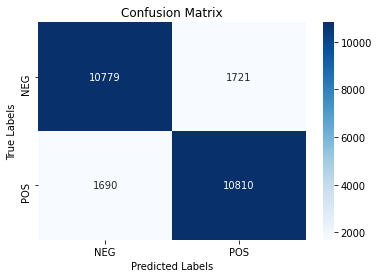

In [73]:
best_model = BERT().to(device)
load_checkpoint(destination_folder +"/12model.pt", best_model)

acc = evaluate(best_model, test_iter)

Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../model/5metrics.pt


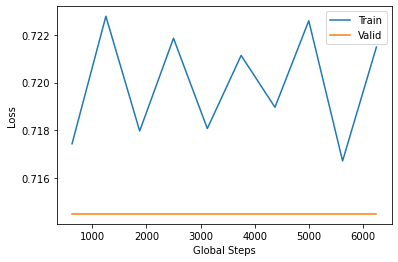

In [86]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder +"/"+  '5metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [89]:
for (text,sentiment), _ in test_iter:
    print(sentiment)
    break

tensor([1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.],
       device='cuda:0')


In [92]:
model = BERT().to(device)

train(model=model, optimizer=optimizer)

initializing bertforsequenceclassification
initializing weights


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

/home/ilee300/workspace/nlp_ofa/notebooks/../model/Nonemetrics.pt
changing encoder number :  12  =>  12
training the model with encoder number of  12
Epoch [1/5], Step [625/6250], Train Loss: 0.7383, Valid Loss: 0.7275
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/12model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/12metrics.pt
Epoch [1/5], Step [1250/6250], Train Loss: 0.7247, Valid Loss: 0.7275
Epoch [2/5], Step [1875/6250], Train Loss: 0.7392, Valid Loss: 0.7275
Epoch [2/5], Step [2500/6250], Train Loss: 0.7246, Valid Loss: 0.7275
Epoch [3/5], Step [3125/6250], Train Loss: 0.7376, Valid Loss: 0.7275
Epoch [3/5], Step [3750/6250], Train Loss: 0.7245, Valid Loss: 0.7275
Epoch [4/5], Step [4375/6250], Train Loss: 0.7385, Valid Loss: 0.7275
Epoch [4/5], Step [5000/6250], Train Loss: 0.7246, Valid Loss: 0.7275
Epoch [5/5], Step [5625/6250], Train Loss: 0.7395, Valid Loss: 0.7275
Epoch [5/5], Step [6250/6250], Train Loss: 0.7250, Valid 

changing encoder number :  12  =>  12
evaluating with max encoder number of  12
Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000     10036
           0     0.4982    1.0000    0.6651      9964

    accuracy                         0.4982     20000
   macro avg     0.2491    0.5000    0.3325     20000
weighted avg     0.2482    0.4982    0.3313     20000



/nethome/ilee300/anaconda3/envs/nlp_ofa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nethome/ilee300/anaconda3/envs/nlp_ofa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nethome/ilee300/anaconda3/envs/nlp_ofa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

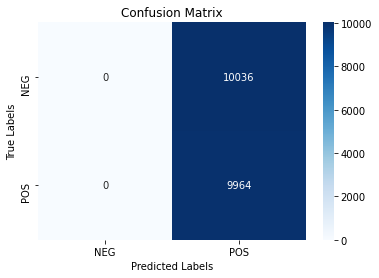

In [93]:
acc = evaluate(model, train_iter, )


In [ ]:
acc

In [ ]:
best_model = BERT().to(device)
load_checkpoint(destination_folder +"/"+ str(5)+ 'model.pt', best_model)
acc = evaluate(best_model, test_iter, max_encoder_num=j)


initializing bertforsequenceclassification
initializing weights


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at



****starting with layer number of  5 ****
/home/ilee300/workspace/nlp_ofa/notebooks/../model/5metrics.pt
changing encoder number :  12  =>  5
training the model with encoder number of  5
Epoch [1/5], Step [625/6250], Train Loss: 0.8440, Valid Loss: 0.8250
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/5model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/notebooks/../model/5metrics.pt
Epoch [1/5], Step [1250/6250], Train Loss: 0.8309, Valid Loss: 0.8250
Epoch [2/5], Step [1875/6250], Train Loss: 0.8434, Valid Loss: 0.8250
Epoch [2/5], Step [2500/6250], Train Loss: 0.8306, Valid Loss: 0.8250
Epoch [3/5], Step [3125/6250], Train Loss: 0.8440, Valid Loss: 0.8250
Epoch [3/5], Step [3750/6250], Train Loss: 0.8304, Valid Loss: 0.8250
Epoch [4/5], Step [4375/6250], Train Loss: 0.8429, Valid Loss: 0.8250
Epoch [4/5], Step [5000/6250], Train Loss: 0.8301, Valid Loss: 0.8250
Epoch [5/5], Step [5625/6250], Train Loss: 0.8443, Valid Loss: 0.8250
Epoch [5/5], Step [6

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading model trained with 5 number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/notebooks/../model/5model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000     12500
           0     0.5000    1.0000    0.6667     12500

    accuracy                         0.5000     25000
   macro avg     0.2500    0.5000    0.3333     25000
weighted avg     0.2500    0.5000    0.3333     25000

accuracy when using  5  layers 0.5
changing encoder number :  12  =>  6
evaluating with max encoder number of  6


/nethome/ilee300/anaconda3/envs/nlp_ofa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nethome/ilee300/anaconda3/envs/nlp_ofa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nethome/ilee300/anaconda3/envs/nlp_ofa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000     12500
           0     0.5000    1.0000    0.6667     12500

    accuracy                         0.5000     25000
   macro avg     0.2500    0.5000    0.3333     25000
weighted avg     0.2500    0.5000    0.3333     25000

accuracy when using  6  layers 0.5
changing encoder number :  12  =>  7
evaluating with max encoder number of  7


/nethome/ilee300/anaconda3/envs/nlp_ofa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nethome/ilee300/anaconda3/envs/nlp_ofa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nethome/ilee300/anaconda3/envs/nlp_ofa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

KeyboardInterrupt: 

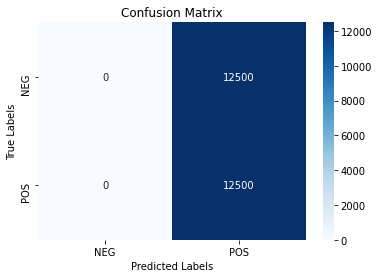

In [77]:
import numpy as np

array = np.empty((8,8))
for i in range(5,13):
    model = BERT().to(device)
    print("\n\n****starting with layer number of ",i,"****")
    train(model=model, optimizer=optimizer, max_encoder_num=i)
    best_model = BERT().to(device)
    print("loading model trained with " + str(i) + " number of layers")
    load_checkpoint(destination_folder +"/"+ str(i)+ 'model.pt', best_model)
    for j in range(5,13):
        acc = evaluate(best_model, test_iter, max_encoder_num=j)
#         acc_dict[(i,j)] = acc
#         array[i-5][j-5] = acc_dict[(i,j)]
        array[i-5][j-5] = acc
        print("accuracy when using ", j, " layers", acc)

Loss for model trained with  5  number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/./data/5metrics.pt


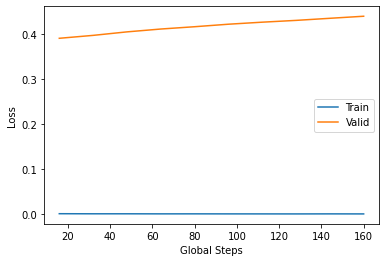

Loss for model trained with  6  number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/./data/6metrics.pt


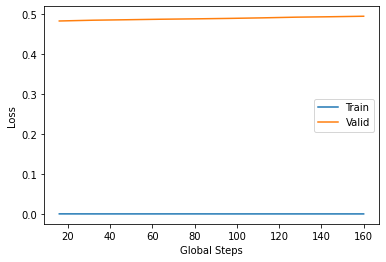

Loss for model trained with  7  number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/./data/7metrics.pt


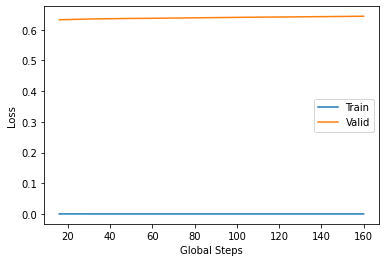

Loss for model trained with  8  number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/./data/8metrics.pt


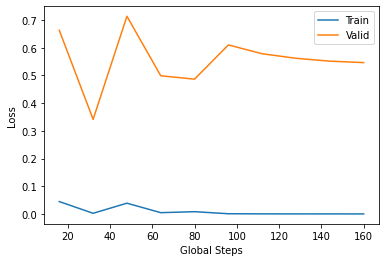

Loss for model trained with  9  number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/./data/9metrics.pt


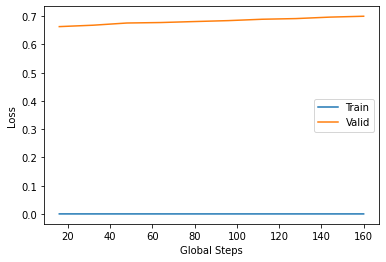

Loss for model trained with  10  number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/./data/10metrics.pt


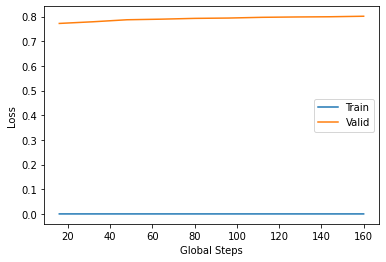

Loss for model trained with  11  number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/./data/11metrics.pt


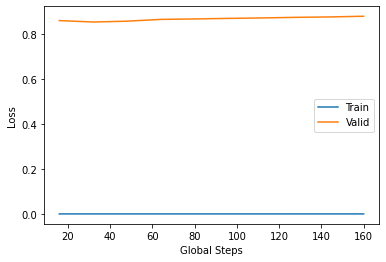

Loss for model trained with  12  number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/./data/12metrics.pt


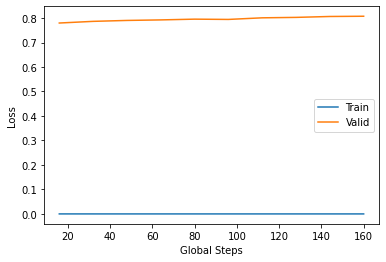

In [37]:
for i in range(5,13):
    print("Loss for model trained with ",i ," number of layers")
    train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder +"/"+ str(i)+ 'metrics.pt')
    plt.plot(global_steps_list, train_loss_list, label='Train')
    plt.plot(global_steps_list, valid_loss_list, label='Valid')
    plt.xlabel('Global Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() 

In [ ]:
best_model = BERT().to(device)
acc_dict = dict()
for i in range(5,13):
    print("loading model trained with " + str(i) + " number of layers")
    load_checkpoint(destination_folder +"/"+ str(i)+ 'model.pt', best_model)

    for j in range(5,13):
        acc = evaluate(best_model, test_iter, max_encoder_num=j)
        acc_dict[(i,j)] = acc
        print("accuracy when using ", j, " layers", acc)

In [ ]:
import numpy as np

array = np.empty((8,8))
for i in range(5,13):
    for j in range(5,13):
        array[i-5][j-5] = acc_dict[(i,j)]


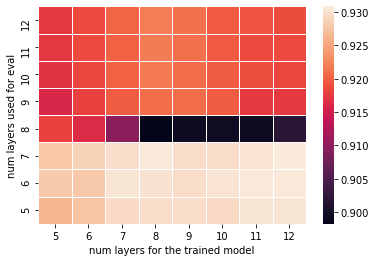

In [53]:
ax = sns.heatmap(array,  linewidth=0.5,xticklabels=list(range(5,13)), yticklabels=list(range(5,13)))
ax.invert_yaxis()
ax.set_ylabel('num layers used for eval')
ax.set_xlabel('num layers used to train model')
# ax.axis([5, 12,5,12])
plt.show()


initializing bertforsequenceclassification
initializing weights


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading model trained with 5 number of layers
Model loaded from <== /home/ilee300/workspace/nlp_ofa/./data/5model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       249
           0     1.0000    1.0000    1.0000       253

    accuracy                         1.0000       502
   macro avg     1.0000    1.0000    1.0000       502
weighted avg     1.0000    1.0000    1.0000       502

accuracy when using  5  layers 1.0
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       249
           0     1.0000    1.0000    1.0000       253

    accuracy                         1.0000       502
   macro avg     1.0000    1.0000    1.0000       502
weighted avg     1.0000    1.0000    1.0000    

Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       249
           0     1.0000    1.0000    1.0000       253

    accuracy                         1.0000       502
   macro avg     1.0000    1.0000    1.0000       502
weighted avg     1.0000    1.0000    1.0000       502

accuracy when using  6  layers 1.0
changing encoder number :  12  =>  7
evaluating with max encoder number of  7
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       249
           0     1.0000    1.0000    1.0000       253

    accuracy                         1.0000       502
   macro avg     1.0000    1.0000    1.0000       502
weighted avg     1.0000    1.0000    1.0000       502

accuracy when using  7  layers 1.0
changing encoder number :  12  =>  8
evaluating with max encoder number of  8
Classification Report:
              precision    recall  f1-score   suppo

Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       249
           0     1.0000    1.0000    1.0000       253

    accuracy                         1.0000       502
   macro avg     1.0000    1.0000    1.0000       502
weighted avg     1.0000    1.0000    1.0000       502

accuracy when using  7  layers 1.0
changing encoder number :  12  =>  8
evaluating with max encoder number of  8
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       249
           0     1.0000    1.0000    1.0000       253

    accuracy                         1.0000       502
   macro avg     1.0000    1.0000    1.0000       502
weighted avg     1.0000    1.0000    1.0000       502

accuracy when using  8  layers 1.0
changing encoder number :  12  =>  9
evaluating with max encoder number of  9
Classification Report:
              precision    recall  f1-score   suppo

Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       249
           0     1.0000    1.0000    1.0000       253

    accuracy                         1.0000       502
   macro avg     1.0000    1.0000    1.0000       502
weighted avg     1.0000    1.0000    1.0000       502

accuracy when using  9  layers 1.0
changing encoder number :  12  =>  10
evaluating with max encoder number of  10
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       249
           0     1.0000    1.0000    1.0000       253

    accuracy                         1.0000       502
   macro avg     1.0000    1.0000    1.0000       502
weighted avg     1.0000    1.0000    1.0000       502

accuracy when using  10  layers 1.0
changing encoder number :  12  =>  11
evaluating with max encoder number of  11
Classification Report:
              precision    recall  f1-score   

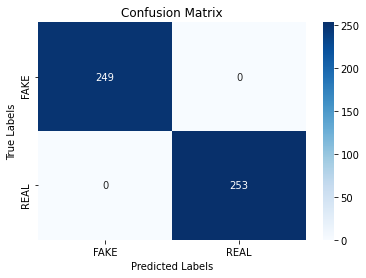

In [54]:
##evaluate using train data
best_model = BERT().to(device)
acc_dict = dict()
for i in range(5,13):
    print("loading model trained with " + str(i) + " number of layers")
    load_checkpoint(destination_folder +"/"+ str(i)+ 'model.pt', best_model)

    for j in range(5,13):
        acc = evaluate(best_model, train_iter, max_encoder_num=j)
        acc_dict[(i,j)] = acc
        print("accuracy when using ", j, " layers", acc)

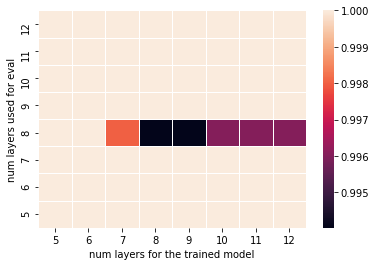

In [55]:
array = np.empty((8,8))
for i in range(5,13):
    for j in range(5,13):
        array[i-5][j-5] = acc_dict[(i,j)]
ax = sns.heatmap(array,  linewidth=0.5,xticklabels=list(range(5,13)), yticklabels=list(range(5,13)))
ax.invert_yaxis()
ax.set_ylabel('num layers used for eval')
ax.set_xlabel('num layers for the trained model')
# ax.axis([5, 12,5,12])
plt.show()